# Analyse descriptives des données.

Réalisation d'analyses descriptives statistiques et graphiques sur différents jeux de données :

In [2]:
import glob, sys, sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#connection à la base de données (à la SGBD)
conn = sqlite3.connect('bdd.sqlite.db')

In [4]:
#Retourne une table de population de tous les pays
def population():
    SQL = 	''' select "Code Pays", Pays, Valeur as Population
from FAOSTAT_2013_population 
order by valeur desc;'''
    return pd.read_sql_query(SQL, con=conn)

#Affichage du tableau de population
print(population())

     Code Pays                      Pays  Population
0          351                     China     1416667
1          100                     India     1252140
2          231  United States of America      320051
3          101                 Indonesia      249866
4           21                    Brazil      200362
..         ...                       ...         ...
166         83                  Kiribati         102
167          8       Antigua and Barbuda          90
168         55                  Dominica          72
169         17                   Bermuda          65
170        188     Saint Kitts and Nevis          54

[171 rows x 3 columns]


In [5]:
#Retourne une table de population malnutrie pour tous les pays
def mal_nutrition():
    SQL = 	''' select "Code zone",
                        "zone",
                        Année,
                        "Unité", 
                        Valeur as "Population mal nutrie",
                        Symbole 
                from FAOSTAT_2013_sous_alimentation;'''
    return pd.read_sql_query(SQL, con=conn)

#Affichage d'une table de population malnutrie pour tous les pays
print(mal_nutrition())

    "Code zone" "zone"      Année     Unité  Population mal nutrie Symbole
0     Code zone   zone  2012-2014  millions                    8.1       F
1     Code zone   zone  2012-2014  millions                    2.6       F
2     Code zone   zone  2012-2014  millions                    0.2       F
3     Code zone   zone  2012-2014  millions                    1.8       F
4     Code zone   zone  2012-2014  millions                    2.0      <2
..          ...    ...        ...       ...                    ...     ...
199   Code zone   zone  2012-2014  millions                    1.8       F
200   Code zone   zone  2012-2014  millions                   11.1       F
201   Code zone   zone  2012-2014  millions                    7.1       F
202   Code zone   zone  2012-2014  millions                    7.0       F
203   Code zone   zone  2012-2014  millions                    6.7       F

[204 rows x 6 columns]


Nous décidons de traier la malnutrition mondial par le prisme du pourcentage de malnutrition par pays.
Afin de symplifier les requêtes futures, nous créons une vue appelée "vue_pourcentage_pauvrete".
Cette vue nous présente les données par ordre décroissant de % de malnutrition.

In [6]:
def create_view(connect):
    SQL =     ''' CREATE VIEW vue_pourcentage_pauverte AS
select  "Code groupe de pays partenaires" as Code_Group_Pays,
        "Groupe de pays partenaires" as Group_Pays, 
        "Code Pays" as Code_Pays,
        Pays, 
        Année, 
        val_pauvreté, 
        Symbole, 
        val_population, 
        percentage
from FAOSTAT_data INNER JOIN  ( -- vue de la jointure entre la table population et sous alimentation et calcul de la pauvreté
        select FAOSTAT_2013_population."Code Pays", 
            FAOSTAT_2013_population.Pays AS Pays, 
              FAOSTAT_2013_sous_alimentation.Année, 
              FAOSTAT_2013_sous_alimentation.Valeur as val_pauvreté,
            FAOSTAT_2013_sous_alimentation.Symbole,
            FAOSTAT_2013_population.Valeur as val_population,
            ((FAOSTAT_2013_sous_alimentation.Valeur/3)/(FAOSTAT_2013_population.Valeur/1000))*100 as percentage
        from FAOSTAT_2013_sous_alimentation INNER JOIN FAOSTAT_2013_population on FAOSTAT_2013_population."Code Pays" =FAOSTAT_2013_sous_alimentation."Code Pays"
    ) on "Code Pays" = FAOSTAT_data."Code pays partenaire" -- jointure pour integration du groupe de pays
where (FAOSTAT_data."Code groupe de pays partenaires" % 100)==0 and FAOSTAT_data."Code groupe de pays partenaires" != 5000
ORDER BY percentage DESC;'''
    
    try:
        #recupération de connection
        cursor = connect.cursor()
        print("Connected to the database")

        #execution de la requête et création de la table
        cursor.execute(SQL)
        connect.commit()
        print("Database created")
    except:
        pass

    #cloture de connection
    cursor.close()
    
    return 

#appel de la fonction de création de vue.
#resoit une connection à une SGBD
create_view(conn)

Connected to the database


On vérifie que tout c'est bien passé.

In [8]:
#Retourne la vue concernant les poucentages de malnutrition pour tous les pays
def percentage():
    SQL = ''' select * from vue_pourcentage_pauverte ;'''
    return pd.read_sql_query(SQL, con=conn)

#affichage de la vue
print(percentage())

     Code_Group_Pays Group_Pays  Code_Pays                      Pays  \
0               5100    Afrique         37  Central African Republic   
1               5200  Amériques         93                     Haiti   
2               5100    Afrique        251                    Zambia   
3               5100    Afrique        181                  Zimbabwe   
4               5100    Afrique         46                     Congo   
..               ...        ...        ...                       ...   
166             5500    Océanie         83                  Kiribati   
167             5500    Océanie        153             New Caledonia   
168             5500    Océanie         70          French Polynesia   
169             5500    Océanie        244                     Samoa   
170             5500    Océanie        155                   Vanuatu   

         Année  val_pauvreté Symbole  val_population  percentage  
0    2012-2014           2.1       F            4616   17.500000  
1

In [9]:
#Retourne la vue concernant les pourcentages de malnutrition pour tous les pays
def percentage_grou_pays():
    
    SQL = ''' 
     select Group_Pays as Regions,
            count(Group_Pays) as nb_pays, 
            avg(percentage) as "Average % of poor nutrition"
    from vue_pourcentage_pauverte 
    group by Group_Pays 
    order by "Average % of poor nutrition" desc;
    '''
    return pd.read_sql_query(SQL, con=conn)

#Affichage de la vue concernant les pourcentages de malnutrition pour tous les pays
print(percentage_grou_pays())

     Regions  nb_pays  Average % of poor nutrition
0    Afrique       45                     7.789801
1       Asie       42                     4.011101
2  Amériques       36                     3.718958
3     Europe       39                     1.166149
4    Océanie        9                     0.851449


In [10]:
# Récupération de la liste des continents
def list_group_pays():
    SQL='''
    select DISTINCT Group_Pays
    from vue_pourcentage_pauverte
    '''
    return pd.read_sql_query(SQL, con=conn)

# Affichage de la liste des continents
print(list_group_pays())

  Group_Pays
0       Asie
1     Europe
2    Afrique
3    Océanie
4  Amériques


# Analyse univarie
Histogramme de malnutrition par continant.

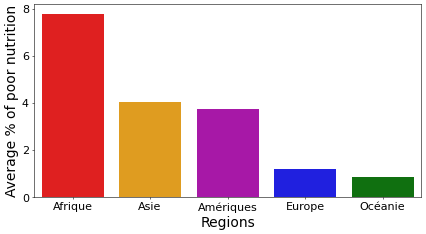

In [11]:
df=percentage_grou_pays()

fig,ax= plt.subplots(figsize=(10,5), dpi=50)
ax.set_xlabel('Average % of poor nutrition', fontsize = 20.0)
ax.set_ylabel('Regions', fontsize = 20.0)

colors=['red', 'orange','m', 'blue','green', 'gray']

sns.barplot(x = 'Regions'  , y =  "Average % of poor nutrition", data = df, palette = colors)
plt.tick_params(axis='both', which='major', labelsize=16)

On observe la grande détresse de l'Afrique en matière de sous alimentation. La situation en Asie et en Amérique sont préocupentes, il est à noter que nous traitons ici de l'amérique dans sa globalité et que probablement l'amérique du Sud soit plus impacté par la malnutrition qu'observé, en mirroir la situation en amérique du Nord devrait être plus favorable. L'Europe et l'océanie semble moins concernés par le problème.

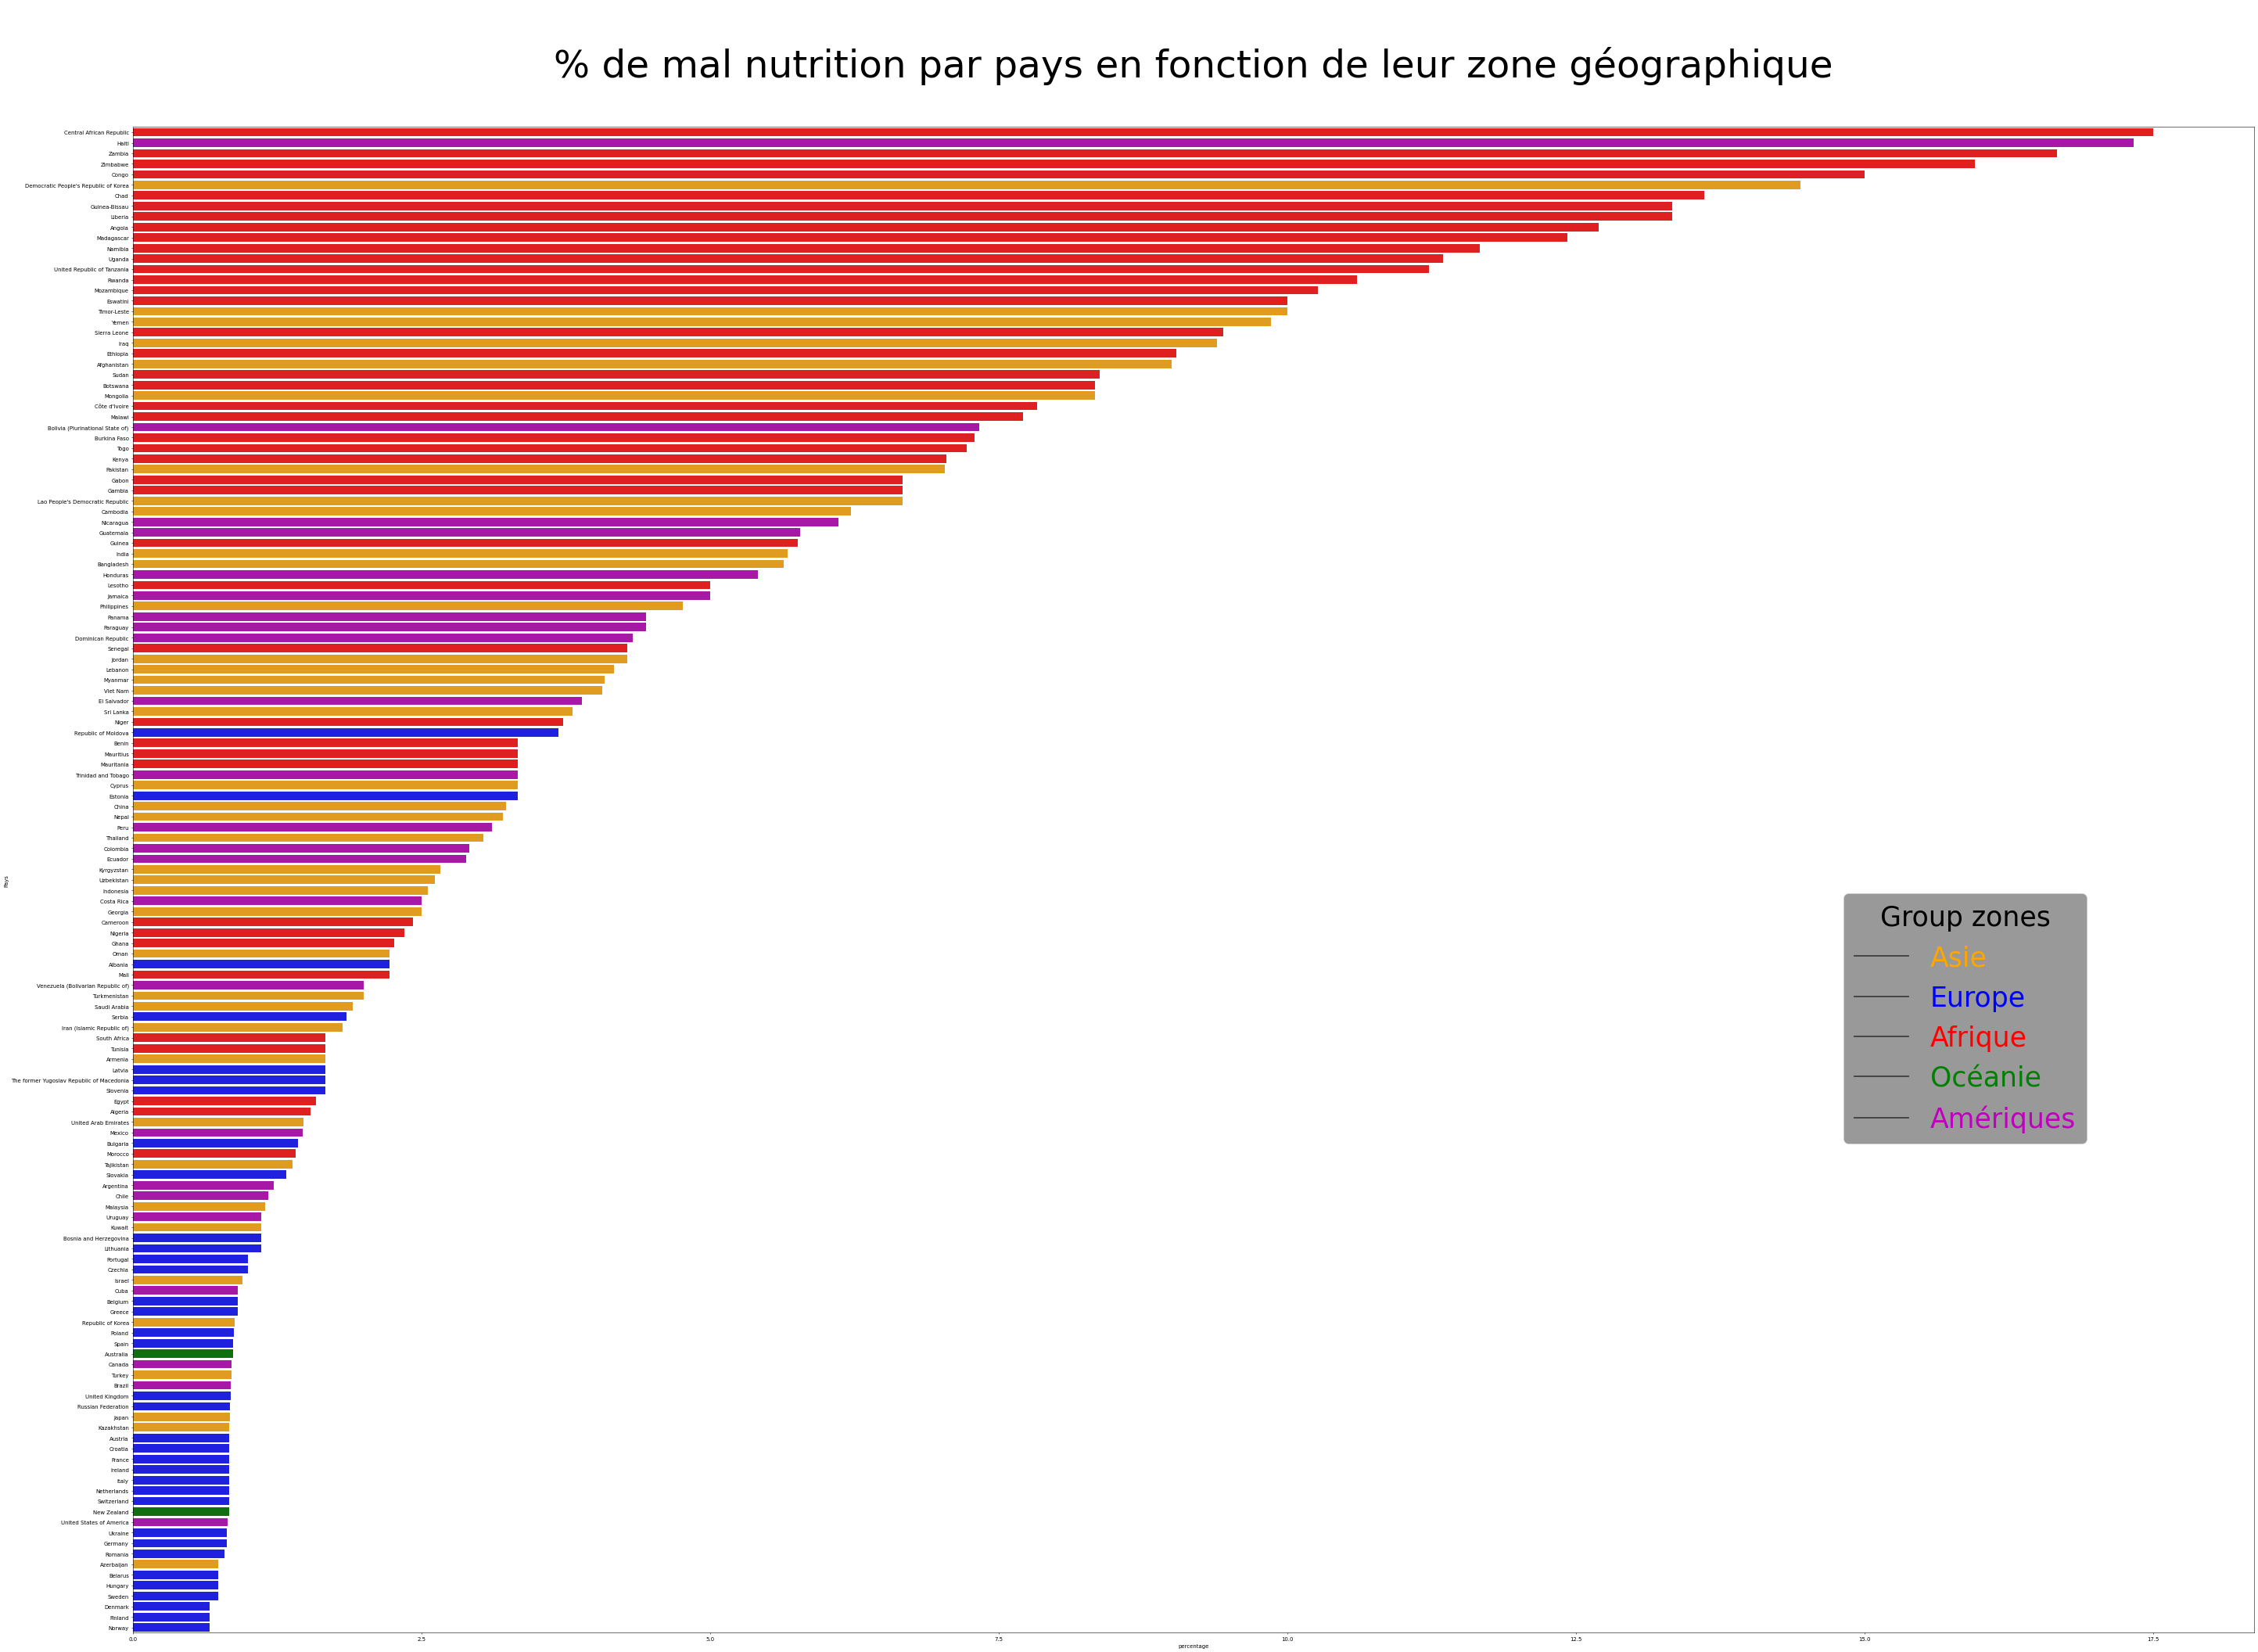

In [12]:
#Affichage par % de malnutrition par pays en fonction de leur zone géographique
df=percentage()
df_grp_pays=list_group_pays()

labels=list_group_pays()["Group_Pays"]
colors=['orange', 'blue','red', 'green','m', 'gray']

pal=[]
for i in df.index:
    if df["Group_Pays"][i]=="Afrique":
        pal.append("red")
    elif df["Group_Pays"][i]=="Europe":
        pal.append("blue")
    elif df["Group_Pays"][i]=="Amériques":
        pal.append("m")
    elif df["Group_Pays"][i]=="Océanie":
        pal.append("green")
    elif df["Group_Pays"][i]=="Asie":
        pal.append("orange")
    else:
        pal.append("gray")

#paramétrage de la figure
fig,ax= plt.subplots(figsize=(70,50), dpi=50)
ax.set_xlabel('pays')
ax.set_ylabel('percentage')
df.dropna(how='any', inplace=True)

#tracé du bar graph de pourcentage
sns.barplot(x = 'percentage', y =  'Pays', data = df, palette = pal)
plt.legend( labels=labels, labelcolor  = colors, bbox_to_anchor=(0.8,0.5), loc=2,
           fontsize=50, facecolor="gray",
           title_fontsize=50, title="Group zones", markerscale=5)

plt.title("\n% de mal nutrition par pays en fonction de leur zone géographique\n", fontsize=70 );

Si on obseve la malnutrition par pays en fonction de leur zone géographique, la tendance se confirme, aux extrèmes nous trouvons les pays africains (en stress nutritionnel). L'europe et l'océanie sont très peu concernés par ce problème, il est à noter qu'il y'avait beaucoup de données manquantes pour cette zone géographique. L'amérique  et l'asie occupent un large spèctre allant d'une situation critique pour Haiti (17.3%) ou la Corée du Nord (14.5%) à une situation très favorable tel le Brésil (0.85 %), les USA (0.82%), la Turquie(0.85%) ou le Japon (0.84%).

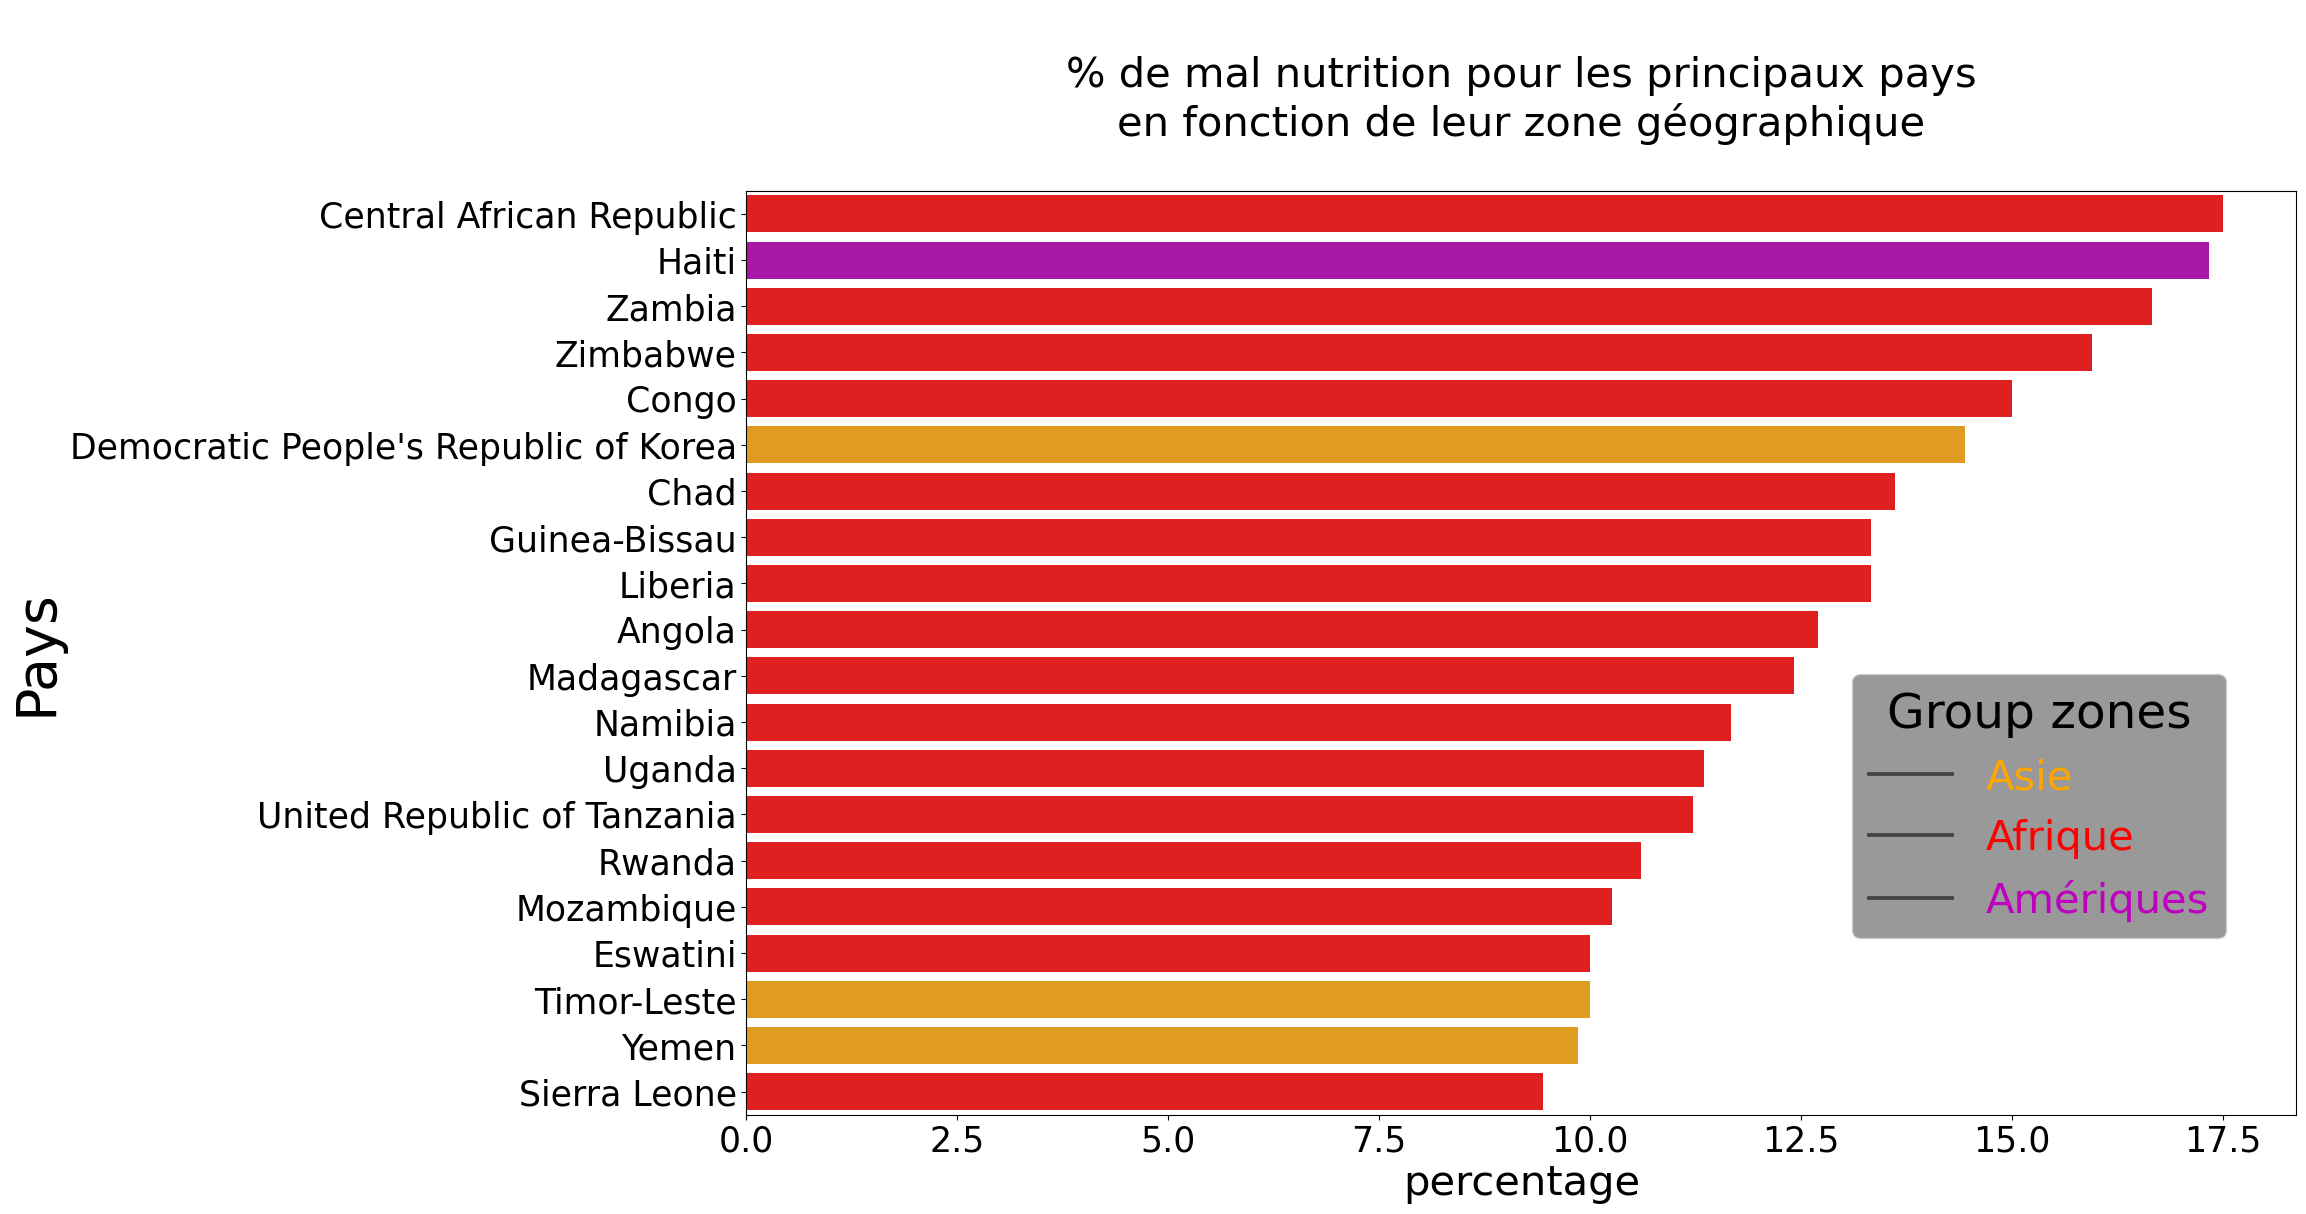

In [13]:
#Affichage de % de mal nutrition pour les principaux pays en fonction de leur zone géographique (un petit Zoom)
palette= "blend:#7AB,#EDA"
fig,ax= plt.subplots(figsize=(20,12), dpi=100)
ax.set_xlabel('pays', fontsize = 30.0)
ax.set_ylabel('percentage', fontsize = 40.0)
colors=['orange', 'red', 'm', 'gray']
try:
    del labels[1]
    del labels[3]
except:
    pass

sns.barplot(x = 'percentage', y =  'Pays', data = df.head(20), palette = pal)
plt.legend( labels=labels, labelcolor  = colors, bbox_to_anchor=(0.7,0.5), loc=2,
           fontsize=30, facecolor="gray",
           title_fontsize=35, title="Group zones", markerscale=5)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title("\n% de mal nutrition pour les principaux pays\nen fonction de leur zone géographique\n", fontsize=30 );

# Exo2
Question 1 : Nombre d'humains sur la planète.

Calculez le nombre total d’humains sur la planète.
Critiquez votre résultat. En cas d’anomalie, analysez et effectuer les corrections nécessaires.
Donnez le résultat de votre calcul pour l'année 2013.

Le nombre obtenu est cohérent avec ce qui est indiqué sur ce site (sachant que les données sont de 2013)       https://www.worldometers.info/world-population/world-population-by-year/
        

In [14]:
def nb_humain_total():
    
    SQL = ''' 
select sum(Valeur)*1000 as "population total monde"  
from FAOSTAT_2013_population 
--on excepte les pays en redondance
where "Code Pays" != 96 and "code Pays" != 128 and "code Pays" != 41 and "code Pays" != 214 
'''
    return pd.read_sql_query(SQL, con=conn)

#Affichage de la vue concernant les poucentages de malnutrition pour tous les pays
print(nb_humain_total())

   population total monde
0              6997326000


Question 2 : Redondances

Pour les datasets « animal », « cereal » et « vegetal », on considère ici les 11 quantités : Disponibilité
intérieure, Production, Importations, Variation, Exportations, Nourriture, Aliments, Animaux,
Semences, Pertes et Traitement.
Identifiez les redondances, en donnant votre réponse sous forme de formule mathématique (pas
besoin de coder ici).
C'est une équation à 3 termes de type (a_1 + a2 + [...] = b_1 + b_2 + [...] = c_1 + c_2 + [...]) ) faisant
intervenir chacune des 11 quantités données ci dessus.
Illustrez cette équation avec l'exemple du blé en France.

On observe que les données sont liées entre elles comme suit :

1ère Formule : animaux + Semences + Pertes + Traitement + Autres Utilisations + Nourriture = Disponibilité intérieure

Application numérique : 7822+748+358+1575+2824+6971 = 20298

2ème Formule : Production + Importations + Variation de stock - Exportations = Disponibilité intérieure

Application numérique : 38614+2055+1131-21502=20298

In [15]:
def quantite_liee_au_ble_france():
    SQL = ''' 
select  *
from FAOSTAT_2013_cereal 
where (Pays IN ('France')) 
    AND ("Code Élément" > 1000) 
    AND (Produit IN ('Blé'))
    '''
    return pd.read_sql_query(SQL, con=conn)

#Affichage de 11 quantitées concernant le blé pour la france
print(quantite_liee_au_ble_france())

    index Code Domaine              Domaine  Code Pays    Pays  Code Élément  \
0    5415          FBS  Bilans Alimentaires         68  France          5511   
1    5416          FBS  Bilans Alimentaires         68  France          5611   
2    5417          FBS  Bilans Alimentaires         68  France          5072   
3    5418          FBS  Bilans Alimentaires         68  France          5911   
4    5419          FBS  Bilans Alimentaires         68  France          5301   
5    5420          FBS  Bilans Alimentaires         68  France          5521   
6    5421          FBS  Bilans Alimentaires         68  France          5527   
7    5422          FBS  Bilans Alimentaires         68  France          5123   
8    5423          FBS  Bilans Alimentaires         68  France          5131   
9    5424          FBS  Bilans Alimentaires         68  France          5154   
10   5425          FBS  Bilans Alimentaires         68  France          5142   

                     Élément  Code Prod

Afin de faciliter les requetes, nous créons une vue 'vue_2013_disp_Kcal_prot'

In [17]:
def create_view_dispo_Kcal_prot(connect):
    SQL =''' CREATE VIEW vue_2013_disp_Kcal_prot as 
    select * from (
        select FAOSTAT_2013_vegetal.Élément , FAOSTAT_2013_vegetal.Produit , FAOSTAT_2013_vegetal."Code Pays" ,FAOSTAT_2013_vegetal.Pays, FAOSTAT_2013_vegetal.Unité , FAOSTAT_2013_vegetal.Valeur 
        from FAOSTAT_2013_vegetal
        WHERE FAOSTAT_2013_vegetal.Unité  LIKE "KCAL%"
        
        UNION 
        
        select  FAOSTAT_2013_vegetal.Élément , FAOSTAT_2013_vegetal.Produit, FAOSTAT_2013_vegetal."Code Pays",FAOSTAT_2013_vegetal.Pays, FAOSTAT_2013_vegetal.Unité , FAOSTAT_2013_vegetal.Valeur 
        from FAOSTAT_2013_vegetal
        WHERE FAOSTAT_2013_vegetal.Unité  LIKE "g/pers%" and FAOSTAT_2013_vegetal."Code Élément" = "674"
    
        union
            
            select FAOSTAT_2013_animal.Élément ,  FAOSTAT_2013_animal.produit,FAOSTAT_2013_animal."Code Pays", FAOSTAT_2013_animal.Pays, FAOSTAT_2013_animal.Unité , FAOSTAT_2013_animal.Valeur
            from FAOSTAT_2013_animal
        WHERE FAOSTAT_2013_animal.Unité  LIKE "KCAL%"
        
        UNION 
        
        select  FAOSTAT_2013_animal.Élément , FAOSTAT_2013_animal.Produit, FAOSTAT_2013_animal."Code Pays", FAOSTAT_2013_animal.Pays, FAOSTAT_2013_animal.Unité , FAOSTAT_2013_animal.Valeur 
        from FAOSTAT_2013_animal
        WHERE FAOSTAT_2013_animal.Unité  LIKE "g/pers%" and FAOSTAT_2013_animal."Code Élément" = "674"
        
        ) as disp_alim, 
        (
        select distinct FAOSTAT_2013_population."Code Pays", FAOSTAT_2013_population.Pays, FAOSTAT_2013_population.Valeur as Population
        from FAOSTAT_2013_population
        ) as tab_final
    where tab_final."Code Pays" != 96 and tab_final."code Pays" != 128 and tab_final."code Pays" != 41 and tab_final."code Pays" != 214 
    and disp_alim."Code Pays" = tab_final."Code Pays";'''
    
    try:
        #récupération de connection
        cursor = connect.cursor()
        print("Connected to the database")

        #éxécution de la requête et création de la table
        cursor.execute(SQL)
        connect.commit()
        print("Database created")
    except:
        print("Pass")
        pass

    #cloture de connection
    cursor.close()
    
    return 

#appel de la fonction de création de vue.
#resoit une connection à une SGBD
create_view_dispo_Kcal_prot(conn)

Connected to the database
Pass


Question 3 : Disponibilité alimentaire (calories, protéines) Calculez (pour chaque pays et chaque produit) la disponibilité alimentaire en kcal par an puis en kg de protéines par an. Vous ferez cela à partir de ces informations :

In [18]:
 def disponibilite_alimentaire_calories():
    SQL = ''' 
select kcal.Pays,
        kcal.Produit,
        kcal.Valeur * 365 as "calories (Kcal/personne/ans)",
        prot.Valeur * 365 as "proteines (g/personne/ans)",      
        kcal.Valeur/(prot.Valeur/1000) as "calories/proteines (kcal/kg)"
from 
    (
    select Pays, Produit, Valeur 
    from vue_2013_disp_Kcal_prot
    where Élément = "Disponibilité alimentaire (Kcal/personne/jour)"
    ) as kcal,
    (
    select Pays, Produit, Valeur 
    from vue_2013_disp_Kcal_prot
    where Élément = "Disponibilité de protéines en quantité (g/personne/jour)"
    ) as prot
where kcal.Pays=prot.Pays and kcal.Produit=prot.Produit
'''
    return pd.read_sql_query(SQL, con=conn)

print(disponibilite_alimentaire_calories())

             Pays                 Produit  calories (Kcal/personne/ans)  \
0     Afghanistan        Abats Comestible                        1825.0   
1     Afghanistan            Beurre, Ghee                        8395.0   
2     Afghanistan                   Crème                        1095.0   
3     Afghanistan  Graisses Animales Crue                        4380.0   
4     Afghanistan      Lait - Excl Beurre                       36500.0   
...           ...                     ...                           ...   
3604        Chine  Viande d'Ovins/Caprins                        6205.0   
3605        Chine        Viande de Bovins                       10585.0   
3606        Chine        Viande de Suides                      134320.0   
3607        Chine     Viande de Volailles                       23725.0   
3608        Chine           Viande, Autre                        1460.0   

      proteines (g/personne/ans)  calories/proteines (kcal/kg)  
0                         281.05  

Question 4 : Ratio énergie/poids
A partir de ces dernières informations, et à partir du poids de la disponibilité alimentaire (pour
chaque pays et chaque produit), calculez pour chaque produit le ratio "énergie/poids", que vous

donnerez en kcal/kg. Vous pouvez vérifier la cohérence de votre calcul en comparant ce ratio aux
données disponibles sur internet, par exemple en cherchant la valeur calorique d'un oeuf.

Si on fait une moyenne des calories d'un oeuf avec notre base, nous obtenons 42 calories. 

Trouvé sur chatGPT:
"Les calories d'un œuf de taille plus petite aura moins de calories qu'un œuf de taille plus importante. Le département de l'agriculture des États-Unis en fait une estimation : entre 40 grammes et 80 calories"

Notre base semble retourner des valeurs cohérentes.

In [20]:
 def ratio_enegie_poid(connect):
    SQL = ''' CREATE VIEW vue_2013_ratio_energie_poid as 
    select kcal.Pays,
            kcal.Produit,
            "kcal/kg" as Unité, 
            ROUND(kcal.Calorie/(prot.Proteine/1000)) as Ratio_Cal_Prot,
            kcal.Calorie as Calorie,
            prot.Proteine as Proteine
    from 
        (
        select Pays, Produit, Valeur as Calorie
        from vue_2013_disp_Kcal_prot
        where Élément = "Disponibilité alimentaire (Kcal/personne/jour)"
        ) as kcal,
        (
        select Pays, Produit, Valeur as Proteine
        from vue_2013_disp_Kcal_prot
        where Élément = "Disponibilité de protéines en quantité (g/personne/jour)"
        ) as prot
    where kcal.Pays=prot.Pays and kcal.Produit=prot.Produit;
    '''
    
    try:
        #récupération de connection
        cursor = connect.cursor()
        print("Connected to the database")

        #execution de la requête et création de la table
        cursor.execute(SQL)
        connect.commit()
        print("Database created")
    except:
        print("Pass")
        pass

    #cloture de connection
    cursor.close()
    
    SQL = '''select *
                from vue_2013_ratio_energie_poid;
    '''
    
    return pd.read_sql_query(SQL, con=conn)

print(ratio_enegie_poid(conn))

Connected to the database
Pass
             Pays                 Produit    Unité  Ratio_Cal_Prot  Calorie  \
0     Afghanistan        Abats Comestible  kcal/kg          6494.0      5.0   
1     Afghanistan            Beurre, Ghee  kcal/kg        766667.0     23.0   
2     Afghanistan                   Crème  kcal/kg         75000.0      3.0   
3     Afghanistan  Graisses Animales Crue  kcal/kg       1200000.0     12.0   
4     Afghanistan      Lait - Excl Beurre  kcal/kg         16340.0    100.0   
...           ...                     ...      ...             ...      ...   
3604        Chine  Viande d'Ovins/Caprins  kcal/kg         14655.0     17.0   
3605        Chine        Viande de Bovins  kcal/kg         14796.0     29.0   
3606        Chine        Viande de Suides  kcal/kg         31670.0    368.0   
3607        Chine     Viande de Volailles  kcal/kg         14607.0     65.0   
3608        Chine           Viande, Autre  kcal/kg          6897.0      4.0   

      Proteine  
0  

Question 5 : Aliments les plus caloriques et protéiques

En considérant les aliments végétaux et animaux, citez 5 aliments parmi les 20 aliments les plus
caloriques

In [22]:
def cinq_parmis_vingt_aliments_les_plus_calorifiques():
    SQL = ''' 
select *
from(
    select Produit, 
            round(avg(Calorie)) as Calorie 
    FROM vue_2013_ratio_energie_poid
    group by Produit
    ORDER BY Calorie desc limit 20
    )
ORDER BY RANDOM() LIMIT 5

'''
    return pd.read_sql_query(SQL, con=conn)

print(cinq_parmis_vingt_aliments_les_plus_calorifiques())

                  Produit  Calorie
0      Plantes Aquatiques      0.0
1               Perciform      5.0
2      Lait - Excl Beurre    174.0
3  Graisses Animales Crue     41.0
4      Poissons Eau Douce      6.0


En utilisant le ratio énergie/poids. Citez 5 aliments parmi les 20 aliments les plus riches en
protéines.

In [23]:
def cinq_parmis_vingt_aliments_les_plus_riches_en_proteines():
    SQL = ''' 
select *
from(
    select Produit, 
            round(avg(Ratio_Cal_Prot)) as Ratio_Cal_Prot 
    FROM vue_2013_ratio_energie_poid
    group by Produit
    ORDER BY Ratio_Cal_Prot desc limit 20
    )
ORDER BY RANDOM() LIMIT 5

'''
    return pd.read_sql_query(SQL, con=conn)

print(cinq_parmis_vingt_aliments_les_plus_riches_en_proteines())

                   Produit  Ratio_Cal_Prot
0   Viande d'Ovins/Caprins         14255.0
1      Viande de Volailles         10369.0
2         Viande de Bovins         11761.0
3       Lait - Excl Beurre         17517.0
4  Poissons Marins, Autres          5343.0


Question 6 : Disponibilité intérieure mondiale des végétaux

Calculez, pour les produits végétaux uniquement, la disponibilité intérieure mondiale exprimée en
kcal.

In [60]:
def dispo_interieur_modial():
    SQL = ''' 
select "Disp interieur" * "Calories", 
        "KCal" as "Unité"
FROM (
    select Pays, 
            Produit,
            sum(Valeur) as "Disp interieur"
    from FAOSTAT_2013_vegetal
    where FAOSTAT_2013_vegetal."Code Élément" = 5301
            and ("Code Pays" != 96 and "code Pays" != 128 and "code Pays" != 41 and "code Pays" != 214 )
    ) AS table_disp,
    (
    select Pays, 
            Produit, 
                sum(Valeur) as "Calories"
    from FAOSTAT_2013_vegetal
    where "Code Élément" = 645
            and ("Code Pays" != 96 and "code Pays" != 128 and "code Pays" != 41 and "code Pays" != 214 )
    ) AS table_calories
where table_disp.Pays=table_calories.Pays and table_disp.Produit=table_calories.Produit
'''
    return pd.read_sql_query(SQL, con=conn)

#Calcul de la disponibilité interieur des vegetaux
print(dispo_interieur_modial())

   "Disp interieur" * "Calories" Unité
0                   4.606757e+10  KCal


Question 7 : Potentiel alimentaire des végétaux
Combien d'humains pourraient être nourris si toute la disponibilité intérieure mondiale de produits
végétaux était utilisée pour la nourriture ? Donnez les résultats en termes de calories, puis de
protéines, et exprimez ensuite ces 2 résultats en pourcentage de la population mondiale.

Pour répondre à cette question, il est nécésaire d'estimer le nombre de calories consommés par jour pour un individu.

La réponce de chatGPT à la question "quel est le besoin moyen en calorie pour les humains" :
Le besoin en calories varie considérablement d'une personne à l'autre en fonction de facteurs tels que l'âge, le sexe, la taille, le poids, le niveau d'activité physique et d'autres considérations de santé. En général, les adultes ont besoin d'environ 2000 à 2500 calories par jour pour maintenir leur poids corporel, mais cela peut varier de 1200 à plus de 3000 calories par jour en fonction des besoins individuels.

Ce qu'on pense, notre planette en termes de nutriments végétaux à la capacité de nourir plus de 18,4 milliard d'individus. Si on en crois le compteur actuelle de la population mondiale, nous serions 7.9 milliard.

In [24]:
def potentiel_allimentaire_des_vegetaux():
    SQL = ''' 
select "Disponibilité Mondial (Kcal)",
            round("Disponibilité Mondial (Kcal)"/2.5) as "Nombre d'individues peut nourrir" 
from(
    select "Disp interieur" * "Calories" as "Disponibilité Mondial (Kcal)"
    FROM (
        select Pays, Produit, sum(Valeur) as "Disp interieur"
        from FAOSTAT_2013_vegetal
        where FAOSTAT_2013_vegetal."Code Élément" = 5301
                 and ("Code Pays" != 96 and "code Pays" != 128 and "code Pays" != 41 and "code Pays" != 214 )
        ) AS table_disp,
        (
        select Pays, Produit, sum(Valeur) as "Calories"
        from FAOSTAT_2013_vegetal
        where "Code Élément" = 645
                 and ("Code Pays" != 96 and "code Pays" != 128 and "code Pays" != 41 and "code Pays" != 214 )
        ) AS table_calories
    where table_disp.Pays=table_calories.Pays and table_disp.Produit=table_calories.Produit) as mondial
    '''
    return pd.read_sql_query(SQL, con=conn)

print(potentiel_allimentaire_des_vegetaux())
res= 18.4/7.9
print(f"\n Notre planette serait en mesure de nourir près de {round(res,2)} plus de personnes qu'aujourd'hui." )
    

   Disponibilité Mondial (Kcal)  Nombre d'individues peut nourrir
0                  4.606757e+10                      1.842703e+10

 Notre planette serait en mesure de nourir près de 2.33 plus de personnes qu'aujourd'hui.


Question 8 : Potentiel alimentaire des végétaux (destinés aux animaux pertes)
Combien d'humains pourraient être nourris si toute la disponibilité alimentaire en produits végétaux
la nourriture végétale destinée aux animaux et les pertes de produits végétaux étaient utilisés pour
de la nourriture ? Donnez les résultats en termes de calories, puis de protéines, et exprimez ensuite
ces 2 résultats en pourcentage de la population mondiale.

Réponse de ChatGPT :
Le besoin en protéines varie également d'une personne à l'autre en fonction de facteurs tels que l'âge, le sexe, la taille, le poids, le niveau d'activité physique et d'autres considérations de santé.

En général, l'Organisation Mondiale de la Santé (OMS) recommande une consommation quotidienne de 0,8 gramme de protéines par kilogramme de poids corporel pour les adultes en bonne santé. Cela signifie qu'une personne pesant 60 kg a besoin d'environ 48 grammes de protéines par jour.

Le poids moyen d'un adulte varie considérablement en fonction de nombreux facteurs, notamment l'âge, le sexe, la taille, l'activité physique, la génétique et l'alimentation. Il est difficile de donner un poids moyen précis pour tous les adultes, mais en général, le poids moyen d'un adulte varie entre 50 et 90 kg.
